# 평가지표
- 정확도(accuracy)
- 오차행렬(confusion grid)
- 정밀도(precision)
- 재현율(recall)
- f1스코어(f1 score)

# Accuracy(정확도)

: 직관적으로 모델 예측 성능을 나타내는 평가지표
   - 이진분류에서 데이터 구성에 따라 성능을 왜곡할 수 있기에 정확도 하나만 사용 x
   - 불균형한 레이블 값 분포에서 모델 성능을 평가하기에 적합하지 않음
       - ex)레이블 테스트 데이터셋 값이 90%가 1이면 다 1로 예측해도 정확도 0.9 나옴

### 타이타닉 생존자 예측에서 여성은 모두 생존으로 판별

- Dummy Estimator 만들기
    - 남자면 사망, 여자면 생존으로 예측

In [30]:
import numpy as np
from sklearn.base import BaseEstimator

class MyDummyEstimator(BaseEstimator):
    def fit(self, X, y):
        pass
    # 남자면 사망, 여자면 생존으로 예측
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i] = 0
            else:
                pred[i]=1
        return pred

- 데이터 전처리 함수들

In [31]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# NULL 처리 함수
def fillna(df):
    df["Age"].fillna(df["Age"].mean(), inplace=True)
    df["Cabin"].fillna('N', inplace=True)
    df["Embarked"].fillna('N', inplace=True)
    df["Fare"].fillna(0, inplace=True)
    return df

# 불필요한 칼럼 삭제
def drop_features(df):
    df.drop(["Name","Ticket","PassengerId"], axis=1, inplace=True)
    return df

# 레이블 인코딩 
def format_features(df):
    df["Cabin"] = df["Cabin"].str[:1]
    features = ["Sex","Cabin","Embarked"]
    for feature in features:
        encoder = LabelEncoder()
        encoder.fit(df[feature])
        df[feature] = encoder.transform(df[feature])
    return df

# 위 세 함수 한꺼번에 실행
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

- Dummy Estimator로 학습/예측/평가

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df = pd.read_csv("titanic_train.csv")
X_titanic_df = titanic_df.drop("Survived",axis=1)
X_titanic_df = transform_features(X_titanic_df)
y_titanic_df = titanic_df["Survived"]

X_train,X_test,y_train,y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                test_size=0.2,random_state=49)

myclf = MyDummyEstimator()
myclf.fit(X_train,y_train)
pred = myclf.predict(X_test)
print("Dummy Classifier의 정확도는 {0:.4f}".format(accuracy_score(pred, y_test)))

Dummy Classifier의 정확도는 0.7765


### MNIST 데이터를 다중분류에서 이진분류로 변경

- Fake Classifier 만들기
    - 모두 0으로 예측

In [33]:
import numpy as np
from sklearn.base import BaseEstimator

class MyFakeClassifier(BaseEstimator):
    def fit(self, X,y):
        pass
    # 모두 0으로 예측
    def predict(self, X):
        return np.zeros(X.shape[0], dtype=bool)

- feature, label 데이터셋 추출

In [34]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

digits = load_digits()
print(digits.data)
print("digits.data의 shape : ",digits.data.shape)
print(digits.target)
print("digits.target의 shape : ",digits.target.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
digits.data의 shape :  (1797, 64)
[0 1 2 ... 8 9 8]
digits.target의 shape :  (1797,)


1797개의 그림들을 8 * 8 해서 64개의 픽셀로 나눴구나 

In [35]:
digits.target==7

array([False, False, False, ..., False, False, False])

- Fake Classifier로 학습/예측/평가

In [36]:
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 49)

print("레이블 테스트 세트 크기 :",y_test.shape)
print("레이브 테스트 세트 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

clf = MyFakeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("모든 예측을 0으로 하여도 정확도는 {0:.4f}".format(accuracy_score(pred,y_test)))

레이블 테스트 세트 크기 : (450,)
레이브 테스트 세트 0과 1의 분포도
0    410
1     40
dtype: int64
모든 예측을 0으로 하여도 정확도는 0.9111


# Confusion Matrix (오차행렬)

In [37]:
array = np.array([["TN","FP"],["FN","TP"]])
matrix= pd.DataFrame({"예측 negative":["TN","FN"],"예측 positive":["FP","TP"]})
matrix.index = np.array(["실제 negative","실제 positive"])
matrix

,예측 negative,예측 positive
실제 negative,TN,FP
실제 positive,FN,TP


In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, pred)

array([[410,   0],
       [ 40,   0]], dtype=int64)

- 오차행렬을 통한 정확도 지표의 문제점 인지 
    - TP와 FP가 0인 걸로 보아 positive로는 예측을 안했음을 알 수 있다. 
    - 그럼에도 불균일한 데이터로 인해 정확도가 0.9가 나온다.

# Precision(정밀도) & Recall(재현율)

In [39]:
matrix

,예측 negative,예측 positive
실제 negative,TN,FP
실제 positive,FN,TP


## 정밀도 
    - 예측을 positive로 한 대상 중에 예측과 실제값이 positive로 일치한 데이터의 비율
    - TP / (FP+TP)
    - 실제 negative인 데이터 예측을 positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우(FP이 증가하면 정밀도 감소)
    - ex) 암 진단, 금융 사기 판별
## 재현율 
    - 실제값이 positive인 대상 중에 예측과 실제값이 positive로 일치한 데이터의 비율
    - TP / (FN+TP)
    - 실제 positive인 데이터 예측을 negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우(FN이 증가하면 정밀도 감소)
    - ex) 스팸 메일

In [40]:
from sklearn.metrics import precision_score, recall_score

print("정밀도 : {0:.4f}".format(precision_score(y_test, pred)))
print("재현율 : {0:.4f}".format(recall_score(y_test, pred)))

정밀도 : 0.0000
재현율 : 0.0000


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}"
         .format(accuracy, precision, recall))

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df = pd.read_csv("titanic_train.csv")
y_titanic_df = titanic_df["Survived"]
X_titanic_df = titanic_df.drop("Survived", axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                   test_size=0.2, random_state=49)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
get_clf_eval(y_test,lr_pred)

오차 행렬
[[97 17]
 [14 51]]
정확도 : 0.8268, 정밀도 : 0.7500, 재현율 : 0.7846


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 정밀도와 재현율의 트레이드 오프
    - 정밀도와 재현율은 상호 보완적 평가 지표
    - 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽습니다.
    - 분류 결정 임곗값이 낮아질수록 positive로 예측할 확률이 높아짐, 재현율 증가, 정밀도 감소

### predict_proba() 메소드 확인

In [43]:
# negative(0)일 확률과 positive(1)일 확률을 np.array 형태로 반환
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba()의 결과 shape :", pred_proba.shape)
print(pred_proba[:3])

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis = 1)
print(pred_proba_result[:3])

pred_proba()의 결과 shape : (179, 2)
[[0.87216382 0.12783618]
 [0.85554957 0.14445043]
 [0.87600574 0.12399426]]
[[0.87216382 0.12783618 0.        ]
 [0.85554957 0.14445043 0.        ]
 [0.87600574 0.12399426 0.        ]]


### Binarizer활용

In [44]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]
# threshold 보다 크면 1, 작으면 0 반환

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


### Binarizer를 이용해 분류 결정 임계값 조정해 예측값 변환

In [45]:
# 분류 결정 임계값 0.5 설정
custom_threshold = 0.5

pred_proba_1 = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

binarizer = Binarizer(custom_threshold)
binarizer.fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 17]
 [14 51]]
정확도 : 0.8268, 정밀도 : 0.7500, 재현율 : 0.7846


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [46]:
# 분류 결정 임계값 0.4 설정
custom_threshold = 0.4

pred_proba_1 = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

binarizer = Binarizer(custom_threshold)
binarizer.fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[91 23]
 [14 51]]
정확도 : 0.7933, 정밀도 : 0.6892, 재현율 : 0.7846


C:\Users\soyunjung\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass threshold=0.4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


임계값을 감소시키니 정밀도가 감소하였음을 알 수 있다.

In [47]:
# 여러 개의 임곗값 설정
thresholds = [0.4,0.45,0.5,0.55,0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    pred_proba_1 = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

    for threshold in custom_threshold:
        binarizer = Binarizer(threshold)
        binarizer.fit(pred_proba_1)
        custom_predict = binarizer.transform(pred_proba_1)

        print("임곗값 :", threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba_class1, thresholds)

TypeError: 'float' object is not iterable

    - 임곗값이 증가할수록 FP가 감소하고 FN이 증가하기 때문에
    - TP/(FP+TP)인 정밀도가 증가
    - TP/(FN+TP)인 재현율이 감소

### precision_recall_curve()를 이용하여 임곗값에 따른 정밀도-재현율 값 추출

In [ ]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임곗값 배열의 shape :", thresholds.shape)
print("반환된 정밀도 배열의 shape :", precisions.shape)
print("반환된 재현율 배열의 shape :", recalls.shape)

print("thresholds 5 sample :", thresholds[:5])
print("precisions 5 sample :", precisions[:5])
print("recalls 5 sample :", recalls[:5])

thr_index =  np.arange(0, thresholds.shape[0],15)
print("샘플 추출을 위한 임곗값 배열의 index 10개 :", thr_index)

print("샘플용 10개의 임곗값 :", np.round(thresholds[thr_index],2))
print("샘플 임곗값별 정밀도 :", np.round(precisions[thr_index],2))
print("샘플 임곗값별 재현율 :", np.round(recalls[thr_index],2))

### 임곗값 변경에 따른 정밀도-재현율 변화 곡선

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 
    # 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', 
             label="precision")
    plt.plot(thresholds, recalls[0:threshold_boundary], label="recall")
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel("threshold value")
    plt.ylabel("precision and recall value")
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, pred_proba_class1)

- 정밀도를 100%로 만드는 법 : 확실한 기준이 되는 경우만 positive로 예측->FP=0
- 재현율을 100%로 만드는 법 : 모든 환자를 positive로 예측->FN=0

# F1 스코어
    - 정밀도와 재현율을 결합한 지표
    - 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 높은 수치
    - 2/(1/recall+1/precision)

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print("F1 스코어 : {0:.4f}".format(f1))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}"
         .format(accuracy, precision, recall, f1))

thresholds = [0.4,0.45,0.5,0.55,0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

# ROC Curve와 AUC
- ROC 곡선
    - FPR이 변할 때, TPR이 어떻게 변하는지를 나타내는 곡선
    - FPR : 실제 negative를 잘못 예측한 비율, FP/(FP+TN)
    - TPR : 재현율, TP/(FN+TP)
- AUC 
    - ROC 곡선 밑의 면적
    - 1에 가까울수록 좋은 수치

In [49]:
from sklearn.metrics import roc_curve

pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

thr_index = np.arange(0,thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index :', thr_index)
print('샘플 index로 추출한 임곗값 : ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR : ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR : ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index : [ 0  5 10 15 20 25 30 35 40 45]
샘플 index로 추출한 임곗값 :  [1.97 0.76 0.64 0.6  0.51 0.27 0.2  0.16 0.12 0.11]
샘플 임곗값별 FPR :  [0.    0.018 0.035 0.088 0.149 0.289 0.377 0.447 0.658 0.746]
샘플 임곗값별 TPR :  [0.    0.492 0.646 0.708 0.785 0.846 0.908 0.938 0.969 0.985]


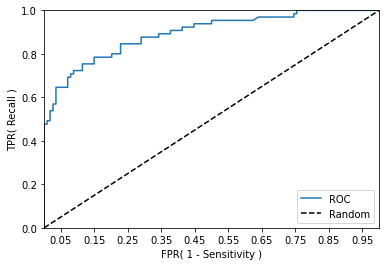

In [52]:
def roc_curve_plot(y_test, pred_proba_c1):
    
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    plt.plot(fprs, tprs, label="ROC")
    plt.plot([0,1],[0,1],"k--",label="Random")
    
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

roc_curve_plot(y_test, pred_proba_class1)

In [53]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print("ROC AUC 값 : {0:.4f}".format(roc_score))

ROC AUC 값 : 0.8943


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}"
         .format(accuracy, precision, recall, f1, roc_auc))
    
    
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[97 17]
 [14 51]]
정확도 : 0.8268, 정밀도 : 0.7500, 재현율 : 0.7846, F1 : 0.7669, AUC : 0.8943
